In [62]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
import matplotlib.pyplot as plt
from skimage.io import imread
import numpy as np

from prepare_lyft_data import extract_single_box, \
    parse_train_csv, level5data, extract_boxed_clouds, \
    get_sample_images, get_train_data_sample_token_and_box, \
    get_pc_in_image_fov, get_bounding_box_corners, \
    get_2d_corners_from_projected_box_coordinates, transform_image_to_world_coordinate,\
transform_world_to_image_coordinate,transform_box_from_world_to_sensor_coordinates,\
transform_box_from_world_to_ego_coordinates,transform_box_from_world_to_flat_vehicle_coordinates,\
transform_box_from_world_to_flat_sensor_coordinates
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud,Quaternion

In [64]:
train_df = parse_train_csv()
sample_token, bounding_box = get_train_data_sample_token_and_box(0, train_df)
first_train_sample = level5data.get('sample', sample_token)

100%|██████████| 22680/22680 [00:02<00:00, 11006.23it/s]


## The details of the rotating axis

Box in world coordinates

In [65]:
bounding_box

label: nan, score: nan, xyz: [2680.28, 698.20, -18.05], wlh: [2.06, 5.49, 2.05], rot axis: [0.00, 0.00, 1.00], ang(degrees): 149.21, ang(rad): 2.60, vel: nan, nan, nan, name: car, token: None

Rotating angle

In [66]:
bounding_box.orientation.degrees

149.2076283924138

Text(0, 0.5, 'y axis')

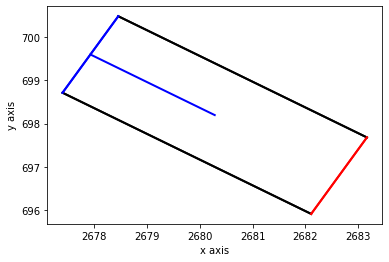

In [67]:
fig,ax=plt.subplots()
view_mtx=np.array([[1,0],[0,1]])
bounding_box.render(ax,view=view_mtx)
plt.xlabel("x axis")
plt.ylabel("y axis")

We could see that the rotation is from x-axis, counterclockwise.

In [68]:
camera_token=first_train_sample['data']['CAM_FRONT']

## Convert to camera coordiante

In [69]:
bounding_box_in_camera_coord=transform_box_from_world_to_sensor_coordinates(bounding_box,camera_token)

Text(0, 0.5, 'z axis')

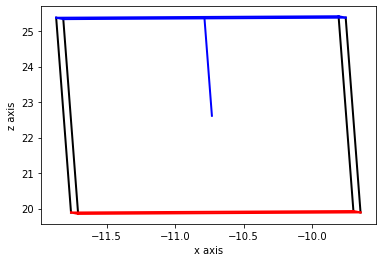

In [70]:
fig,ax=plt.subplots()
view_mtx=np.array([[1,0,0],[0,0,1],[0,1,0]])
bounding_box_in_camera_coord.render(ax,view=view_mtx)
plt.xlabel("x axis")
plt.ylabel("z axis")

In [71]:
bounding_box_in_camera_coord

label: nan, score: nan, xyz: [-10.76, 1.15, 22.63], wlh: [2.06, 5.49, 2.05], rot axis: [0.56, -0.59, 0.58], ang(degrees): 119.19, ang(rad): 2.08, vel: nan, nan, nan, name: car, token: None

In [72]:
bounding_box_in_camera_coord.corners().shape

(3, 8)

In [73]:
bounding_box_in_camera_coord.corners()

array([[-11.86951527,  -9.8065801 ,  -9.75460282, -11.817538  ,
        -11.76105938,  -9.6981242 ,  -9.64614692, -11.7090821 ],
       [  0.19929048,   0.147843  ,   2.19980184,   2.25124932,
          0.09053389,   0.03908641,   2.09104524,   2.14249272],
       [ 25.37393514,  25.41573955,  25.37608721,  25.3342828 ,
         19.88808486,  19.92988927,  19.89023693,  19.84843252]])

In [74]:
maxz=bounding_box_in_camera_coord.corners()[2,:].max()
minz=bounding_box_in_camera_coord.corners()[2,:].min()

In [75]:
dz=maxz-minz
np.arccos(5.49/dz)*180/np.pi

9.559350508183776

It seems that the camera is slightly tilted.

Use bottom corners?

In [76]:
bounding_box_in_camera_coord.bottom_corners()

array([[ -9.75460282, -11.817538  , -11.7090821 ,  -9.64614692],
       [  2.19980184,   2.25124932,   2.14249272,   2.09104524],
       [ 25.37608721,  25.3342828 ,  19.84843252,  19.89023693]])

## Convert to car ego coordinate

In [77]:
bounding_box_in_ego_coord=transform_box_from_world_to_ego_coordinates(bounding_box,camera_token)

In [78]:
bounding_box_in_ego_coord

label: nan, score: nan, xyz: [24.08, 10.89, 1.13], wlh: [2.06, 5.49, 2.05], rot axis: [-0.62, -0.17, 0.77], ang(degrees): 1.97, ang(rad): 0.03, vel: nan, nan, nan, name: car, token: None

Text(0, 0.5, 'y axis')

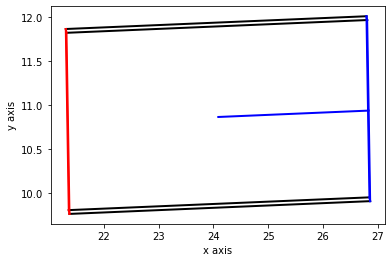

In [79]:
fig,ax=plt.subplots()
view_mtx=np.array([[1,0,0],[0,1,0],[0,0,1]])
bounding_box_in_ego_coord.render(ax,view=view_mtx)
plt.xlabel("x axis")
plt.ylabel("y axis")

The ego car is not exactly flat!

## Convert to flat vehicle coordinates

In [80]:
bounding_box_in_flat_vehicle_coord=transform_box_from_world_to_flat_vehicle_coordinates(bounding_box,camera_token)

Text(0, 0.5, 'y axis')

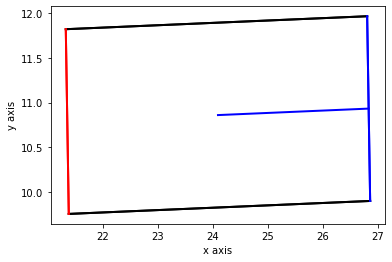

In [81]:
fig,ax=plt.subplots()
view_mtx=np.array([[1,0,0],[0,1,0],[0,0,1]])
bounding_box_in_flat_vehicle_coord.render(ax,view=view_mtx)
plt.xlabel("x axis")
plt.ylabel("y axis")

In [82]:
bounding_box_in_flat_vehicle_coord

label: nan, score: nan, xyz: [24.09, 10.86, 1.21], wlh: [2.06, 5.49, 2.05], rot axis: [0.00, 0.00, 1.00], ang(degrees): 1.51, ang(rad): 0.03, vel: nan, nan, nan, name: car, token: None

## Convert ego to flat sensor coordinates

Investigate the transformation

In [83]:
sample_data_token=camera_token
sd_record = level5data.get("sample_data", sample_data_token)
cs_record = level5data.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
sensor_record = level5data.get("sensor", cs_record["sensor_token"])
pose_record = level5data.get("ego_pose", sd_record["ego_pose_token"])

# Move box to ego vehicle coord system parallel to world z plane
ypr = Quaternion(cs_record["rotation"]).yaw_pitch_roll
yaw = ypr[0]

In [84]:
np.array(ypr)*180/np.pi

array([-75.06181379,  88.49741718, -14.69265635])

In [85]:
inv_ypr=Quaternion(cs_record["rotation"]).inverse.yaw_pitch_roll

In [86]:
np.array(inv_ypr)*180/np.pi

array([89.61270704, -0.24061729, 88.54654913])

This makes sense. Rotate z-axis by 90 degree, and then rotate x by 90 degree.

## Try the conversion from world to flat sensor coordinates

In [87]:
bounding_box_in_flat_sensor_coord=transform_box_from_world_to_flat_sensor_coordinates(bounding_box,camera_token)

Text(0, 0.5, 'z axis')

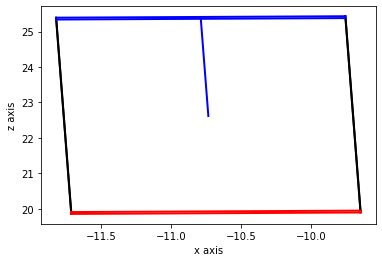

In [88]:
fig,ax=plt.subplots()
view_mtx=np.array([[1,0,0],[0,0,1],[0,1,0]])
bounding_box_in_flat_sensor_coord.render(ax,view=view_mtx)
plt.xlabel("x axis")
plt.ylabel("z axis")

In [89]:
bounding_box_in_flat_sensor_coord.orientation.degrees

119.82643353765953

In [ ]:
first_train_sample['data']

In [ ]:
lidar_token=first_train_sample['data']['LIDAR_TOP']
demo_lidar_file_path=level5data.get_sample_data_path(lidar_token)

In [ ]:
lcp=LidarPointCloud.from_file(demo_lidar_file_path)

In [ ]:
plt.plot(lcp.points[0,:],lcp.points[1,:],'.',markersize=0.2)
plt.xlim([-50,50])
plt.ylim([-50,50])

In [ ]:
level5data.render_sample_data(lidar_token)

In [ ]:
lidar_token=first_train_sample['data']['LIDAR_FRONT_RIGHT']
level5data.render_sample_data(lidar_token)

In [ ]:
lidar_token=first_train_sample['data']['LIDAR_FRONT_LEFT']
level5data.render_sample_data(lidar_token)

In [ ]:
lidar_token=first_train_sample['data']['CAM_FRONT_RIGHT']
level5data.render_sample_data(lidar_token)

In [ ]:
cam_token = first_train_sample['data']['CAM_FRONT']

box_corners = get_bounding_box_corners(bounding_box, cam_token)

# check)image
cam_image_file = level5data.get_sample_data_path(cam_token)
cam_image_mtx = imread(cam_image_file)

xmin, xmax, ymin, ymax = get_2d_corners_from_projected_box_coordinates(box_corners)

random_depth = 20
image_center = np.array([[(xmax + xmin) / 2, (ymax + ymin) / 2, random_depth]]).T

In [ ]:
lidar_token=first_train_sample['data']['LIDAR_TOP']
level5data.get_sample_data(lidar_token)

In [ ]:
image_wc = transform_image_to_world_coordinate(image_center, cam_token)

In [ ]:
image_wc

### confirm that the projection is correct

In [ ]:
transform_world_to_image_coordinate(image_wc,cam_token)

In [ ]:
image_center

## Dissect the steps

In [ ]:
def normalization(input_array):
    input_array[0:2,:]=input_array[0:2,:]*input_array[2:3,:].repeat(2,0).reshape(2,input_array.shape[1])
    return input_array

In [ ]:
image_array=np.copy(image_center)
camera_token=cam_token

In [ ]:
image_array=normalization(image_array)
image_array=np.concatenate((image_array.ravel(),np.array([1])))
image_array=image_array.reshape(4,1)

In [ ]:
image_array

In [ ]:
sd_record = level5data.get("sample_data", camera_token)
cs_record = level5data.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
sensor_record = level5data.get("sensor", cs_record["sensor_token"])
pose_record = level5data.get("ego_pose", sd_record["ego_pose_token"])

# inverse the viewpoint transformation


cam_intrinsic_mtx = np.array(cs_record["camera_intrinsic"])
view=cam_intrinsic_mtx
viewpad=np.eye(4)
viewpad[: view.shape[0], : view.shape[1]] = view
image_in_cam_coord = np.dot(np.linalg.inv(viewpad), image_array)

print("image_in_cam_coord",image_in_cam_coord)
# TODO: think of how to do normalization properly
# image_in_cam_coord = image_in_cam_coord / image_in_cam_coord[3:].ravel()

# homogeneous coordinate to non-homogeneous one
image_in_cam_coord = image_in_cam_coord[0:3, :]

sens_to_pose_rot_mtx = Quaternion(cs_record['rotation']).rotation_matrix

image_in_pose_coord = np.dot(sens_to_pose_rot_mtx, image_in_cam_coord)
t = np.array(cs_record['translation'])
for i in range(3):
    image_in_pose_coord[i, :] = image_in_cam_coord[i, :] + t[i]
    

print("in pose record:", image_in_pose_coord)

pose_to_world_rot_mtx = Quaternion(pose_record['rotation']).rotation_matrix

image_in_world_coord = np.dot(pose_to_world_rot_mtx,
                              image_in_pose_coord)
t = np.array(pose_record['translation'])
for i in range(3):
    image_in_world_coord[i, :] = image_in_world_coord[i, :] + t[i]

In [ ]:
image_in_world_coord

In [ ]:
transform_world_to_image_coordinate(image_in_world_coord,cam_token)

In [ ]:
image_in_cam_coord[2:3,:].repeat(3,0).reshape(3,image_array.shape[1])

In [ ]:
def project_image_to_rect(uv_depth):
    ''' Input: nx3 first two channels are uv, 3rd channel
               is depth in rect camera coord.
        Output: nx3 points in rect camera coord.
    '''
    
    n = uv_depth.shape[0]
    x = ((uv_depth[:,0]-c_u)*uv_depth[:,2])/f_u + b_x
    y = ((uv_depth[:,1]-c_v)*uv_depth[:,2])/f_v + b_y
    pts_3d_rect = np.zeros((n,3))
    pts_3d_rect[:,0] = x
    pts_3d_rect[:,1] = y
    pts_3d_rect[:,2] = uv_depth[:,2]
    return pts_3d_rect

## Only to camera coordinates

In [ ]:
cam_intrinsic_mtx = np.array(cs_record["camera_intrinsic"])
view=cam_intrinsic_mtx
viewpad=np.eye(4)
viewpad[: view.shape[0], : view.shape[1]] = view
image_in_cam_coord = np.dot(np.linalg.inv(viewpad), image_array)

print("image_in_cam_coord",image_in_cam_coord)

In [ ]:
from lyft_dataset_sdk.utils.geometry_utils import view_points

In [ ]:
view_points(image_in_cam_coord[0:3,:],view=cam_intrinsic_mtx,normalize=True)